In [1]:
# !pip install stellargraph[demos]

In [1]:
import stellargraph as sg
import os
import sys
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from stellargraph.layer import GCN_LSTM

import datetime
import random
random.seed(10)

2022-05-15 22:41:54.881888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-15 22:41:54.883072: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-15 22:42:45.313887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-15 22:42:45.316756: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-15 22:42:45.317707: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-F3GKG0K): /proc/driver/nvidia/version does not exist
2022-05-15 22:42:45.343615: I tensorflow/core/platform/cpu_fe

In [2]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25
seq_len = 3
pre_len = 1

#adjacency matrix
grid_points = pd.read_csv('grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

In [3]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [4]:
def data_preparation(datafile):
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]


    # only PM2_5
    df = df[['dateTime','lat','long','pm2_5']]

    # TODO: Add buffer and consider train-data for range
    lat_range = {'min': df.lat.min(), 'max': df.lat.max()}
    long_range = {'min': df.long.min(), 'max': df.long.max()}

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    df = df[(df.dateTime>=360)] 

    # only PM2_5
#     df = df[['dateTime','lat_grid','long_grid','pm2_5
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
    columns = df.columns
#     df = df[columns[2:]]
    df = df.fillna(0)
    
    return df

In [5]:
# df = data_preparation('PM Datasets/2021-01-23_all.csv')

In [6]:
# df

In [7]:
# !pip install missingno

In [8]:
# import missingno as msno
# import matplotlib.pyplot as plt
# df = data_preparation('PM Datasets/2021-01-23_all.csv')
# msno.bar(df, figsize=(12, 6), fontsize=12, color='steelblue')

In [9]:
def train_test_split(df, grid_points_indices, train_size):
#     random.seed(10)
    time_len = df.shape[1]
    train_size = int(time_len * train_size) 
    train_data = df.iloc[:, :train_size]
    train_data = train_data.reindex(grid_points_indices,fill_value=0)
    train_data = np.array(train_data)
    test_data = df.iloc[:, train_size:]
    test_data = test_data.reindex(grid_points_indices,fill_value=0)
    test_data = np.array(test_data)
    return train_data, test_data

In [10]:
def scale_data(train_data, test_data):
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)
    test_scaled = (test_data - min_pm) / (max_pm - min_pm)
    return train_scaled, test_scaled

In [11]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [12]:
def my_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()  
    loss = mse(y_pred[y_true>0], y_true[y_true>0] )
    return loss

In [13]:
def prepare_train_data(df, grid_points_indices, train_size = 0.8):
    train_data, test_data = train_test_split(df, grid_points_indices, train_size)
    print("Train data: ", train_data.shape)
    print("Test data: ", test_data.shape)
    train_scaled, test_scaled = scale_data(train_data, test_data)
    trainX, trainY, testX, testY = sequence_data_preparation(
        seq_len, pre_len, train_scaled, test_scaled
    )
    print('trainX: ', trainX.shape)
    print('trainY: ', trainY.shape)
    print('testX: ', testX.shape)
    print('testY: ', testY.shape)
    return trainX, trainY, testX, testY, train_data

In [14]:
def train_model(model, n_epochs, trainX, trainY, testX, testY, train_data, save_path = None, out_df = True):
    cb = TimingCallback()
    net = model
    history = net.fit(
            trainX,
            trainY,
            epochs = n_epochs,
            batch_size = 1,
            shuffle=True,
            verbose=0,
            validation_data=[testX, testY],
            callbacks=[cb]
        )

    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)
    
#     print(
#         "Mean Train loss: ",
#         sum(tf.sqrt(history.history["loss"]))*max_pm/len(history.history["loss"]),
#         "\n Last Train loss: ",
#         tf.sqrt(history.history["loss"][-1])*max_pm,
#         "\n Mean Test loss:",
#         sum(tf.sqrt(history.history["val_loss"]))*max_pm/len(history.history["val_loss"]),
#         "\n Last Test loss:",
#         tf.sqrt(history.history["val_loss"][-1])*max_pm,
#     #     "\nTrain time ", traintime,
#         "\n Train time callbacks", sum(cb.logs)
        
#     )
    df = pd.DataFrame()
    df['Mean Train loss'] = [sum(tf.sqrt(history.history["loss"]).numpy())*max_pm/len(history.history["loss"])]
    df['Last Train loss'] = [tf.sqrt(history.history["loss"][-1]).numpy()*max_pm]
    df['Mean Test loss'] = [sum(tf.sqrt(history.history["val_loss"])).numpy()*max_pm/len(history.history["val_loss"])]
    df['Last Test loss'] = [tf.sqrt(history.history["val_loss"][-1]).numpy()*max_pm]
    df['Train time callbacks'] = [sum(cb.logs)]
#     display(df)
    
    fig = sg.utils.plot_history(history, return_figure=True)
    if save_path is not None:
        fig.savefig(save_path)
    return df

In [15]:
def eval_model(model, testX, testY):
    net = model
    output = net.predict(testX)
    # yhat = model.predict(testX)

    ## actual train and test values
    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    test_true = np.array((testY * (max_pm - min_pm)) + min_pm)

    ## Rescale model predicted values
    test_output = np.array((output * (max_pm - min_pm)) + min_pm)
    # test_rescpred = np.array((yhat * (max_pm - min_pm)) + min_pm)

    # # Masked predicted values
    # mask_train = tf.sign(trainY)
    mask_test = tf.sign(testY)
    # train_rescpred = train_rescpred*(mask_train)
    test_output = test_output*(mask_test)
    test_mse = my_loss(test_true, test_output)
    test_rmse = tf.sqrt(test_mse)
    print("Test RMSE: ", test_rmse)
    return test_output, test_true

In [16]:
def plot_predictions(test_output, test_true, save_path=None):
    ##all test result visualization
    fig = plt.figure(figsize=(15, 8))
    # test_output, test_true = eval(model, testX, testY )
    a_pred = test_output[test_true>0]
    a_true = test_true[test_true>0]
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("test points")
    plt.ylabel("PM2.5")
    plt.legend(loc="best", fontsize=10)
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

In [17]:
def define_model(gc_sizes, gc_activations, lstm_sizes, lstm_activations, lr):
    tf.random.set_seed(45)
    gcn_lstm = GCN_LSTM(
            seq_len=seq_len,
            adj=adj,
            gc_layer_sizes = gc_sizes,
            gc_activations = gc_activations,
            lstm_layer_sizes = lstm_sizes,
            lstm_activations = lstm_activations,
        )
    x_input, x_output = gcn_lstm.in_out_tensors()
    model = Model(inputs=x_input, outputs=x_output)
    opt = tf.optimizers.Adam(learning_rate = lr)
    model.compile(optimizer=opt, loss=my_loss)
#     print(model.summary())
    return model

In [18]:
# tf.random.set_seed(45)
# gcn_lstm = GCN_LSTM(
#         seq_len=seq_len,
#         adj=adj,
#         gc_layer_sizes=[4, 4],
#         gc_activations=["relu", "relu"],
#         lstm_layer_sizes=[4],
#         lstm_activations=["tanh"],
#     )
# x_input, x_output = gcn_lstm.in_out_tensors()
# model = Model(inputs=x_input, outputs=x_output)
# opt = tf.optimizers.Adam(learning_rate = 0.01)
# model.compile(optimizer=opt, loss=my_loss)
# print(model.summary())

In [19]:
# df = data_preparation('PM Datasets/2020-12-01_all.csv')
# # train_data, test_data = train_test_split(df, grid_points_indices, train_size = 0.8)
# for i in range(2, 8):
#     if i<10:
#         datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
#     else:
#         datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
#     df1 = data_preparation(datafile)
#     df = pd.concat([df,df1], axis=1)
#     df = df.fillna(0)
# trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = 0.8)
# # train_model(100, trainX, trainY, testX, testY, train_data)
# test_output, test_true = eval(model, testX, testY)

In [20]:
def main_forecast(df, gc_sizes, gc_activations, lstm_sizes, lstm_activations, lr, train_fraction, test_date, history_days):
    model = define_model(gc_sizes, gc_activations, lstm_sizes, lstm_activations, lr)
    trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = train_fraction)
    out = train_model(model, 100, trainX, trainY, testX, testY, train_data)
    out['GCN sizes'] = gc_sizes
    out['LSTM sizes'] = lstm_sizes
    out['History (in days)'] = [history_days]
    out['Test Date'] = [test_date]
#     display(out)
#     test_output, test_true = eval_model(model, testX, testY)
#     plot_predictions(test_output, test_true)
    return out

# Experiments

## Varying grid sizes on 7 Dec

In [21]:
df = data_preparation('PM Datasets/2020-12-01_all.csv')
for i in range(2, 8):
    datafile = 'PM Datasets/2020-12-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:9: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  if __name__ == '__main__':


Train data:  (270, 36)
Test data:  (270, 6)
trainX:  (33, 270, 3)
trainY:  (33, 270)
testX:  (3, 270, 3)
testY:  (3, 270)


ValueError: Length of values (2) does not match length of index (1)

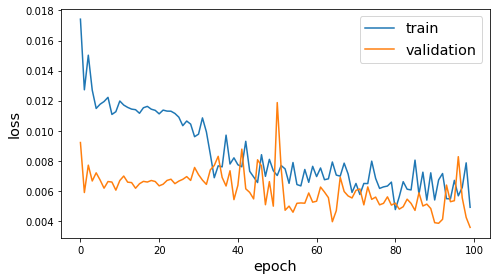

In [22]:
out_results = pd.DataFrame()
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.86, '7 Dec', 6)) 
# out_results.append(main_forecast(df, [8, 8], ["relu", "relu"], [4], ["tanh"], 0.01, 0.86, '7 Dec', 6)) 
# out_results.append(main_forecast(df, [16, 16], ["relu", "relu"], [4], ["tanh"], 0.01, 0.86, '7 Dec', 6)) 
# out_results.append(main_forecast(df, [32, 32], ["relu", "relu"], [4], ["tanh"], 0.01, 0.86, '7 Dec', 6)) 
# out_results.append(main_forecast(df, [4, 4, 4], ["relu", "relu", "relu"], [4], ["tanh"], 0.01, 0.86, '7 Dec', 6)) 
# out_results.append(main_forecast(df, [4, 8, 16], ["relu", "relu", "relu"], [4], ["tanh"], 0.01, 0.86, '7 Dec', 6)) 
# out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [8], ["tanh"], 0.01, 0.86, '7 Dec', 6)) 
# out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [16], ["tanh"], 0.01, 0.86, '7 Dec', 6)) 
# out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [32], ["tanh"], 0.01, 0.86, '7 Dec', 6)) 
# out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4, 4], ["tanh", "tanh"], 0.01, 0.86, '7 Dec', 6))
# out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4, 8], ["tanh", "tanh"], 0.01, 0.86, '7 Dec', 6)) 

# out_results.to_csv('out_grid_sizes.csv')

In [30]:
out_results['GCN sizes'] = '[4, 4]'

In [33]:
list1 = [4, 4]

In [34]:
''.join(str(e) for e in list1)

'44'

In [31]:
out_results

,GCN sizes
0,"[4, 4]"
1,"[4, 4]"


## Varying number of days in history

In [ ]:
out_results = pd.DataFrame()

## 7 Dec

In [ ]:
df = data_preparation('PM Datasets/2020-12-04_all.csv')
for i in range(5, 8):
    datafile = 'PM Datasets/2020-12-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.75, '7 Dec', 3)) 

In [ ]:
df = data_preparation('PM Datasets/2020-12-01_all.csv')
for i in range(2, 8):
    datafile = 'PM Datasets/2020-12-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.86, '7 Dec', 6)) 

In [ ]:
df = data_preparation('PM Datasets/2020-11-27_all.csv')
for i in range(28, 31):
    datafile = 'PM Datasets/2020-11-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
for i in range(1, 8):
    datafile = 'PM Datasets/2020-12-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
df = df.fillna(0)
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.91, '7 Dec', 10)) 

In [ ]:
df = data_preparation('PM Datasets/2020-11-22_all.csv')
for i in range(23, 31):
    datafile = 'PM Datasets/2020-11-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
for i in range(1, 8):
    datafile = 'PM Datasets/2020-12-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
df = df.fillna(0)
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.94, '7 Dec', 15)) 

## 18 Nov


In [4]:
df = data_preparation('PM Datasets/2020-11-15_all.csv')
for i in range(16, 19):
    datafile = 'PM Datasets/2020-11-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.75, '18 Nov', 3))

In [5]:
df = data_preparation('PM Datasets/2020-11-12_all.csv')
for i in range(13, 19):
    datafile = 'PM Datasets/2020-11-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.86, '18 Nov', 6))

In [6]:
df = data_preparation('PM Datasets/2020-11-08_all.csv')
for i in range(9, 19):
    datafile = 'PM Datasets/2020-11-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.91, '18 Nov', 10))

In [7]:
df = data_preparation('PM Datasets/2020-11-03_all.csv')
for i in range(4, 19):
    datafile = 'PM Datasets/2020-11-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.94, '18 Nov', 15))

## 10 Jan

In [8]:
df = data_preparation('PM Datasets/2021-01-07_all.csv')
for i in range(8, 11):
    datafile = 'PM Datasets/2021-01-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.75, '10 Jan', 3))

In [9]:
df = data_preparation('PM Datasets/2021-01-04_all.csv')
for i in range(5, 11):
    datafile = 'PM Datasets/2021-01-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.86, '10 Jan', 6))

In [10]:
df = data_preparation('PM Datasets/2020-12-31_all.csv')
for i in range(1, 11):
    datafile = 'PM Datasets/2021-01-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.91, '10 Jan', 10))

In [11]:
df = data_preparation('PM Datasets/2020-12-26_all.csv')
for i in range(27, 32):
    datafile = 'PM Datasets/2020-12-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
for i in range(1, 11):
    datafile = 'PM Datasets/2021-01-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)
out_results.append(main_forecast(df, [4, 4], ["relu", "relu"], [4], ["tanh"], 0.01, 0.94, '10 Jan', 15))

In [94]:
out_results.to_csv('out_history.csv')